# Task 01:

- Goals:

  1. Create a histogram for the "Team Score" metric with all 262,144 possible vehicle configuration combinations.

  2. Establish a threshold in the histogram that significantly reduces the possible configurations.

### Download the Setups CSV

In [ ]:
!gdown https://drive.google.com/uc?id=1aW6UmbDXuvWq5VjUrMSjho3UyugbhVAG

Downloading...
From: https://drive.google.com/uc?id=1aW6UmbDXuvWq5VjUrMSjho3UyugbhVAG
To: /content/team_setups.csv
100% 16.2M/16.2M [00:00<00:00, 43.4MB/s]


### Read the CSV

- First import dependencies

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

- Read the data from the CSV archive

In [ ]:
data = pd.read_csv('/content/team_setups.csv')

- Checking some informations and statistics about the data:

In [ ]:
print("The data has {} rows and {} columns".format(data.shape[0], data.shape[1]))
print("The average score is {:.2f} and the standard deviation is {:.2f}".format(data['Team_Score'].mean(), data['Team_Score'].std()))

The data has 262144 rows and 7 columns
The average score is 672.38 and the standard deviation is 67.33


- Visualize the data distribution

In [ ]:
# Create a box plot
fig = px.box(data, x='Team_Score', title='Team Score Distribution')

# Customize the box plot (optional)
fig.update_traces(marker=dict(size=4))  # Set marker size
fig.update_layout(showlegend=False)  # Hide the legend (if not needed)

# Show the box plot
fig.show()

### Creating the cutoff filter

- The cutoff value chosen here was selected based on the graph's visualization. To ensure a clear and easily comprehensible visualization, I decided to select only approximately 30 data samples.

In [ ]:
cutoff = 870
cutoff_len = (data['Team_Score'] > cutoff).sum()
print("We will be the Team Scores above {}, resulting in {} samples, which correspond to {:.2f}% of the data".format(cutoff, cutoff_len, cutoff_len/data.shape[0]*100))

We will be the Team Scores above 870, resulting in 31 samples, which correspond to 0.01% of the data


- Now let's prepare the data and visualize it

In [ ]:
# Setting the color palette
data['Cutoff'] = 'Less than {}'.format(cutoff)  # Default color
data.loc[data['Team_Score'] >= cutoff, 'Cutoff'] = 'Higher than {}'.format(cutoff)  # Values higher than 580 should be colored differently

# Maping the values for the histogram
color_map = {
    'Less than 870': '#64CCC5',
    'Higher than 870': '#176B87'
}

In [ ]:
# Crie o histograma
fig = px.histogram(data, x="Team_Score", color="Cutoff", title="Team Score Distribution", nbins=70, color_discrete_map=color_map)
fig.update_xaxes(title_text="Team Score")
fig.update_yaxes(title_text="Count")

# Adicione uma linha vertical no valor desejado (por exemplo, 600)
fig.add_shape(
    dict(
        type='line',
        x0=cutoff,
        x1=cutoff,
        y0=0,
        y1=25000,
        line=dict(color='#04364A', width=2)  # Defina a cor e a espessura da linha
    )
)

# Exiba o gráfico
fig.show()

### Filtered data

- Now, based on the chosen cutoff, separate the data.

In [ ]:
filtered_df = data[data['Cutoff'] == 'Higher than 870']

In [ ]:
filtered_df.head(5)

Break     Engine Suspension   Front_Wing Gearbox      Rear_Wing  \
0      Onyx  Cloudroar    Horizon       Virtue  Vector        Typhoon   
1  Wildcore  Cloudroar    Horizon       Virtue  Vector        Typhoon   
2      Onyx  Cloudroar      Sigma       Virtue  Vector        Typhoon   
3      Onyx  Cloudroar    Horizon       Virtue  Vector  Transcendence   
4      Onyx  Cloudroar    Horizon  Thunderclap  Vector        Typhoon   

   Team_Score           Cutoff  
0       897.0  Higher than 870  
1       892.0  Higher than 870  
2       890.0  Higher than 870  
3       890.0  Higher than 870  
4       888.0  Higher than 870

- Add the column indicating the setup and removing the 'Cutoff' column

In [ ]:
filtered_df['setup'] = range(1, len(filtered_df) + 1)

columns = ['setup'] + [col for col in filtered_df.columns if col != 'setup']
filtered_df = filtered_df[columns]

filtered_df = filtered_df.iloc[:, :-1]

In [ ]:
filtered_df.head(2)

setup     Break     Engine Suspension Front_Wing Gearbox Rear_Wing  \
0      1      Onyx  Cloudroar    Horizon     Virtue  Vector   Typhoon   
1      2  Wildcore  Cloudroar    Horizon     Virtue  Vector   Typhoon   

   Team_Score  
0       897.0  
1       892.0

In [ ]:
filtered_df.to_csv('filtered_TeamScore.csv', index=False)

# Task 02:
 - Goals:
    1. Use the filter from Task 01 and the NetworkX library to create a directed graph.
    2. Choose whether the vertex size will be proportional to the "Team Score" (red vertex) or to the "Out Degree" of the cards (black vertex).
    3. With the graph from the previous item, create a graph for the Probability Density Function (PDF) of the "Out Degree" property of the vertices associated with the setup cards, using the NetworkX library and the Seaborn library (KDE function).

### Read the Data and create the graph

- Import dependencies

In [ ]:
import networkx as nx
import csv

- Create Graph object and nodes:
  - The code below processes each row in the CSV, where each row represents a setup and its associated components, and while doing that adds nodes to the graph.
  - For each setup, a setup node is added with a 'setup' node type and a 'team_score' attribute indicating the setup's team score.
  - For each component associated with the setup, a component node is added, and an edge is established from the component node to the corresponding setup node in the graph.

In [ ]:
G = nx.DiGraph()

In [ ]:
# Read the CSV and add the nodes to the graph using it
with open('/content/filtered_TeamScore.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for index, row in enumerate(csv_reader):
        setup = row['setup']
        team_score = float(row['Team_Score'])
        G.add_node(setup, ntype='setup', team_score=team_score)  # Add setup node with red color and lower opacity
        for component in row.keys():
            if component != 'setup' and component != 'Team_Score':
                component_node = row[component]
                G.add_node(component_node, ntype='component')  # Add component node
                G.add_edge(component_node, setup)  # Reverse the edge direction to point from component to setup

- Now, to visualize the graph representation:
  - First, I set the colors of the nodes according to their types.
  - Then, I calculate the out-degree of the 'component' nodes.
  - Now it's possible to set up the size of the nodes:
    - Here, I chose to change the size of the 'component' nodes based on their out-degree.
    - For the 'setup' nodes, I selected the size based on the team score of each setup.
  - With these settings in place, you can proceed to plot the graph.

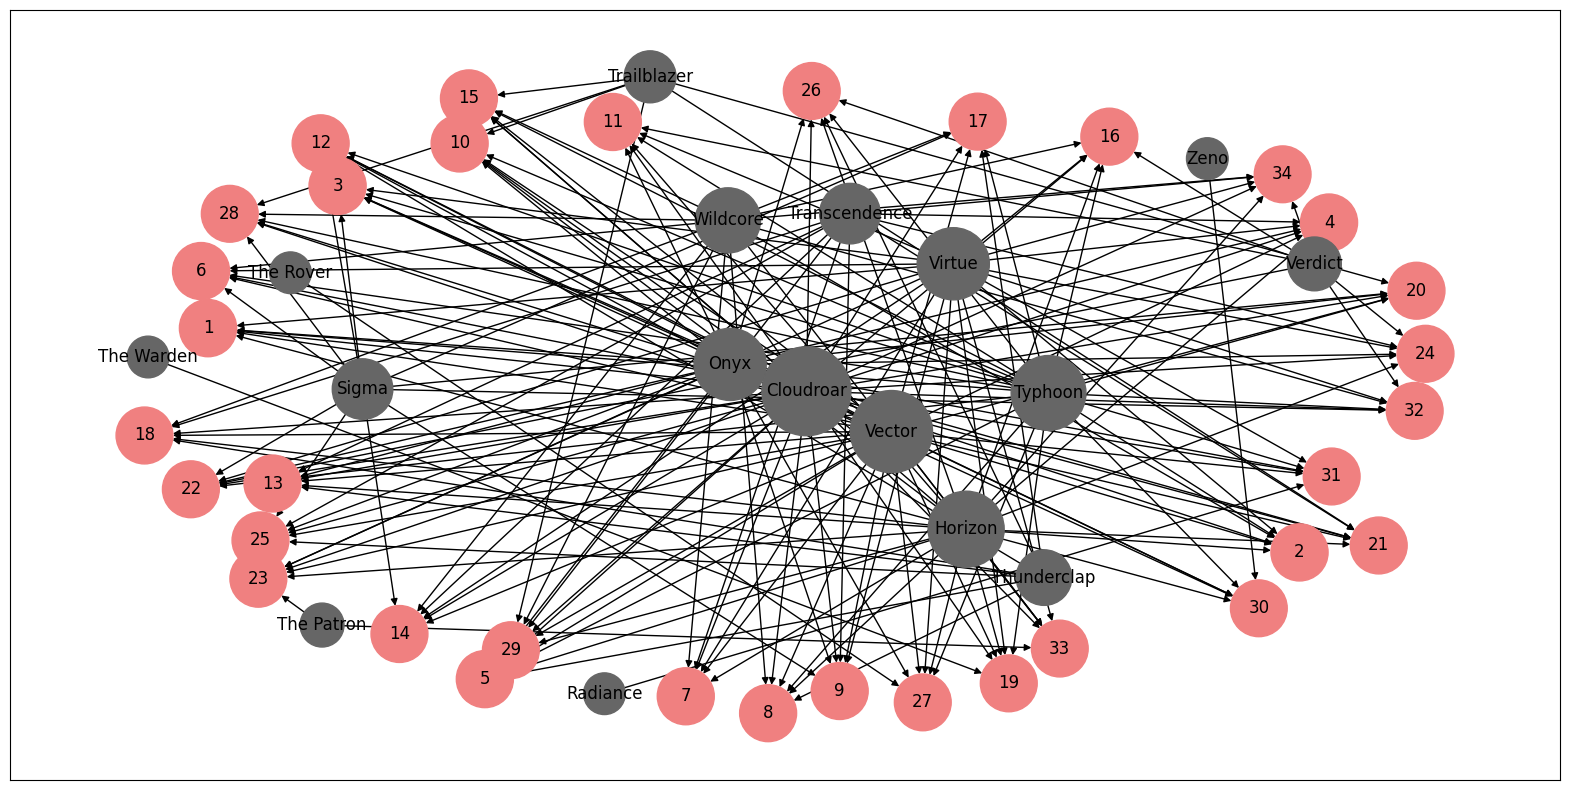

In [ ]:
# Visualize the graph with the spring layout
pos = nx.spring_layout(G, k=15 / (G.order() ** 0.5))
#pos = nx.random_layout(G)

# Separate the nodes into setups and components
colors = ['#666666' if G.nodes[node]['ntype'] == 'component' else 'lightcoral' for node in G.nodes()]

# Calcular o out_degree de cada nó componente
out_degrees_component = {node: G.out_degree(node) for node in G.nodes() if G.nodes[node]['ntype'] == 'component'}

# Extract the node size based on Team_Score
setup_sizes = ode_sizieie = [800 + 100*out_degrees_component[node] if G.nodes[node]['ntype'] == 'component' else 800 + G.nodes[node]['team_score'] for node in G.nodes()]

# Draw the component nodes in light blue
fig,ax = plt.subplots(1,1,figsize=(20,10))
nx.draw_networkx(G, pos=pos, with_labels=True, node_color=colors, node_size=setup_sizes)

plt.show()

### Creating the KDE visualization

- Before exploring the PDF for the out degree o component nodes, I created a different graph, but representin a similar approach:

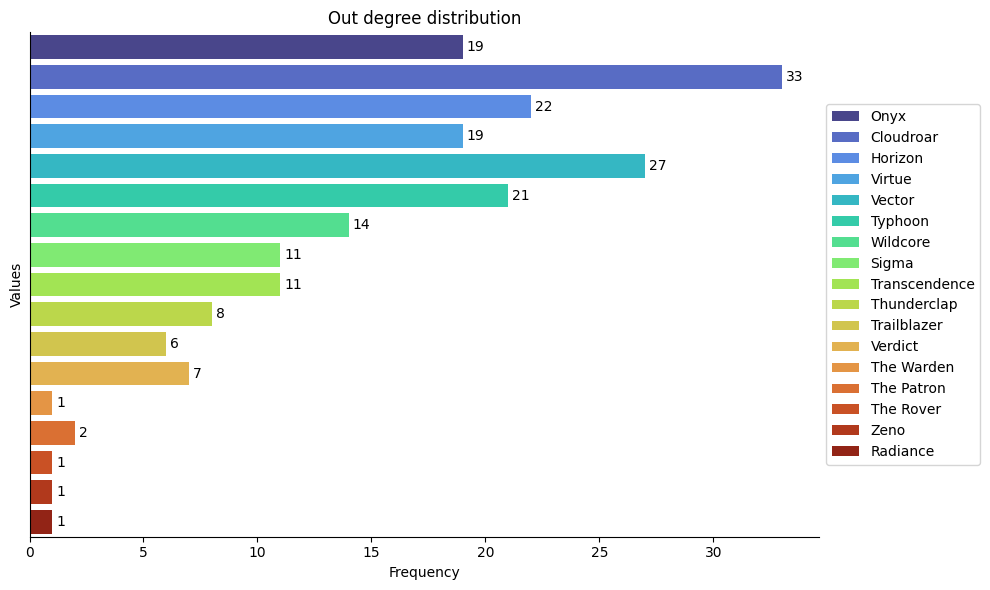

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)

x = list(out_degrees_component.values())
y = list(out_degrees_component.keys())

ax = sns.barplot(x=x, y=y, hue=y, dodge=False, ax=ax, palette='turbo')
ax.tick_params(left=False, labelleft=False)
for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3, fontsize=10)
ax.legend(bbox_to_anchor=(1, .5), loc='center left')
sns.despine()

plt.ylabel('Values')
plt.xlabel('Frequency')
plt.title('Out degree distribution')

plt.tight_layout()
plt.show()

- Now, we can proceed to the requested PDF plot:

<ipython-input-184-269b833dfb7c>:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




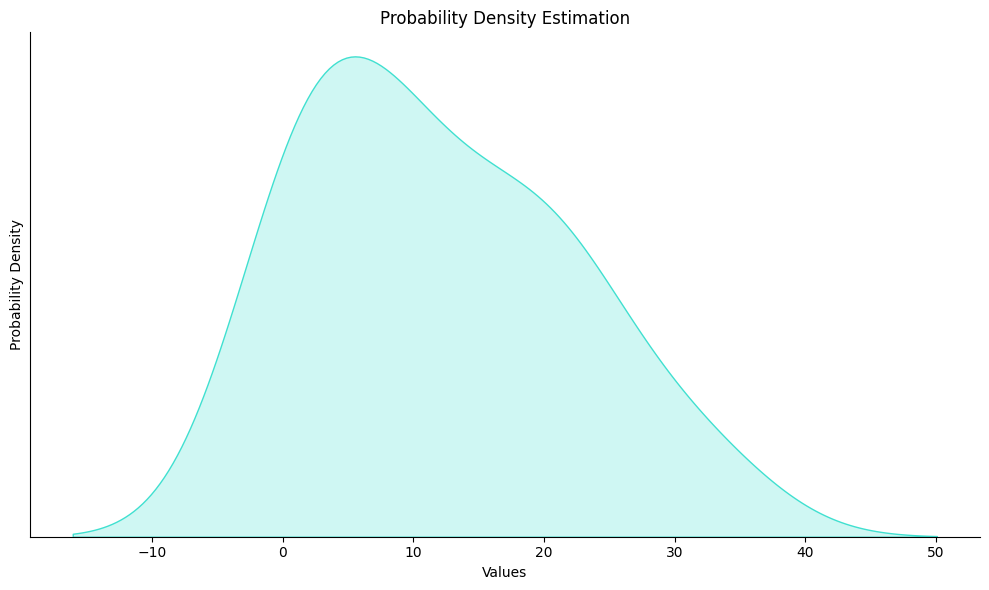

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)

# Plot the KDE using Seaborn
sns.kdeplot(data=x, ax=ax, color='turquoise', shade=True)

ax.tick_params(left=False, labelleft=False)
ax.set_xlabel('Values')
ax.set_ylabel('Probability Density')
ax.set_title('Probability Density Estimation')
sns.despine()

plt.tight_layout()
plt.show();


# Task 03:
 - Goals:
  1. Create a bipartite graph for the bottles in the game F1 Clash and their corresponding properties, with two groups: Bottles and Properties.
  2. The size of the Property vertices will be proportional to the "Out Degree" of the vertices.
  3. A plot using the nxviz library for a circular layout.

### Setup the data

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

- The data was generated and stored in a CSV file;

In [ ]:
!gdown https://drive.google.com/uc?id=1Csx6a75mtiZx1EImYYQ_M1Yh9M_EK3-0

Downloading...
From: https://drive.google.com/uc?id=1Csx6a75mtiZx1EImYYQ_M1Yh9M_EK3-0
To: /content/boost.csv
100% 1.42k/1.42k [00:00<00:00, 6.10MB/s]


- While the data is available in a CSV format, I'll choose to convert it into a Python dictionary for my convenience. This step is not strictly mandatory, but I've opted for it based on personal preference.

In [ ]:
boost = {}
with open('/content/boost.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        driver = row["Boost_name"]
        stats = {key: int(value) for key, value in row.items() if key != "Boost_name"}
        boost[driver] = stats

print(boost)

{'Tsar': {'Speed': 0, 'Cornering': 15, 'Power_Unit': 0, 'Reliability': 0, 'Pit_Stop': 0, 'Overtaking': 0, 'Defending': 10, 'Race_Start': 0, 'Tyre_Management': 25}, 'Frost': {'Speed': 0, 'Cornering': 0, 'Power_Unit': 0, 'Reliability': 10, 'Pit_Stop': 0, 'Overtaking': 0, 'Defending': 0, 'Race_Start': 15, 'Tyre_Management': 25}, 'Tulip': {'Speed': 0, 'Cornering': 0, 'Power_Unit': 0, 'Reliability': 20, 'Pit_Stop': 20, 'Overtaking': 0, 'Defending': 10, 'Race_Start': 0, 'Tyre_Management': 0}, 'Dragon': {'Speed': 0, 'Cornering': 0, 'Power_Unit': 15, 'Reliability': 0, 'Pit_Stop': 0, 'Overtaking': 20, 'Defending': 0, 'Race_Start': 0, 'Tyre_Management': 15}, 'Kawaii': {'Speed': 0, 'Cornering': 20, 'Power_Unit': 0, 'Reliability': 0, 'Pit_Stop': 15, 'Overtaking': 0, 'Defending': 0, 'Race_Start': 15, 'Tyre_Management': 0}, 'Pretzel': {'Speed': 0, 'Cornering': 0, 'Power_Unit': 15, 'Reliability': 0, 'Pit_Stop': 10, 'Overtaking': 0, 'Defending': 0, 'Race_Start': 0, 'Tyre_Management': 25}, 'Vice': {'Sp

### Create the Bipartite Graph

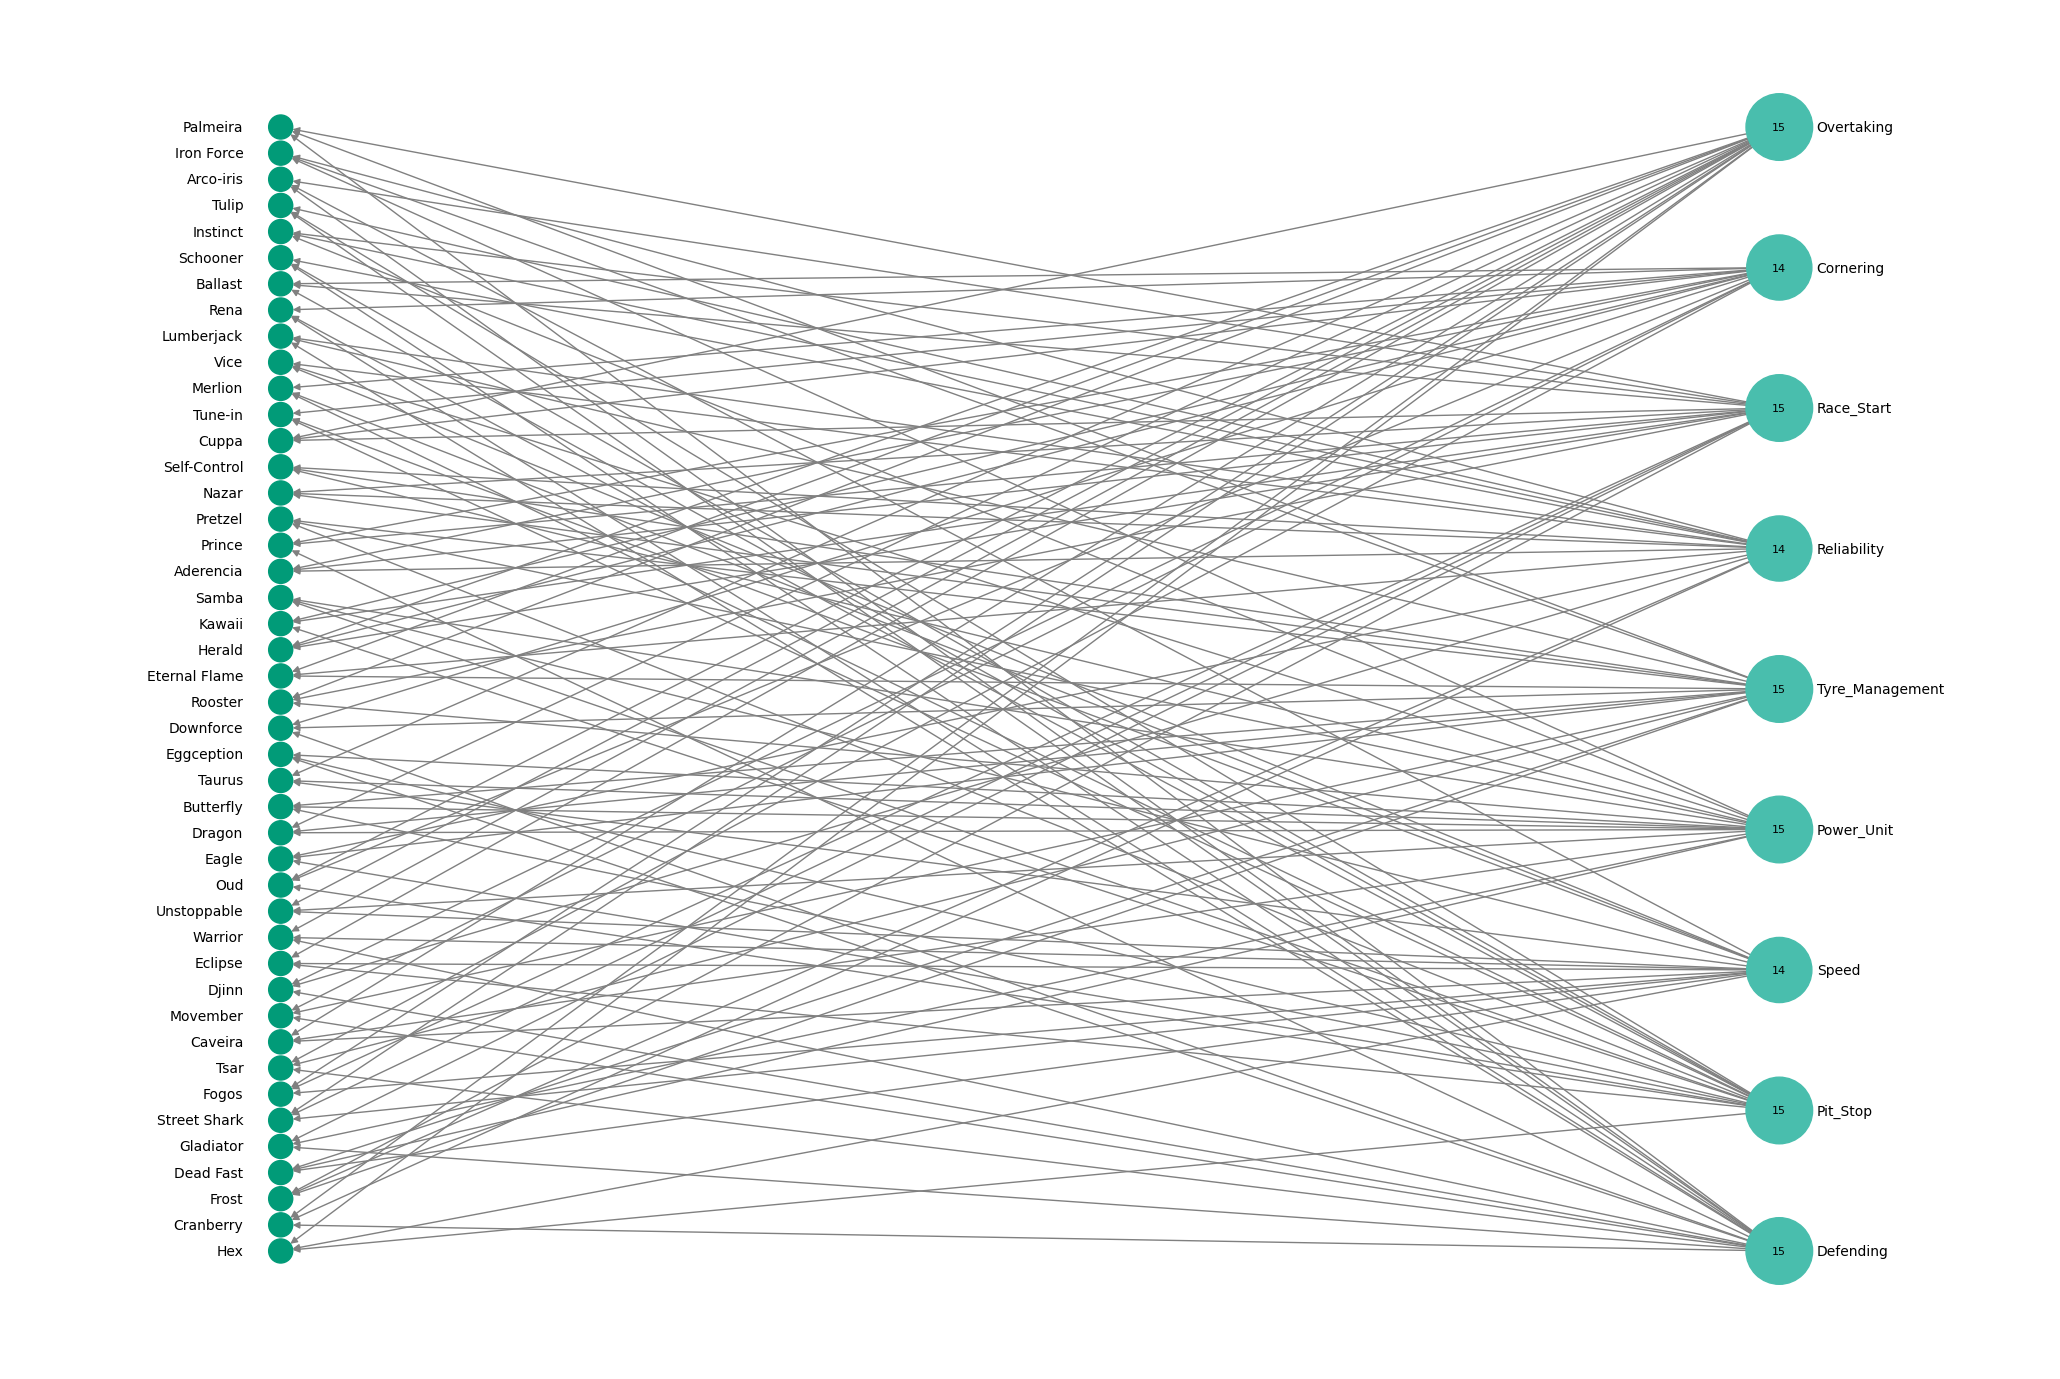

In [ ]:
# Create a Directed graph first
B = nx.DiGraph()

# Separate the nodes according to its side, left-boost and right-attributes
boost_nodes = list(boost.keys())
attribute_nodes = list(boost[boost_nodes[0]].keys())

# Add the node and the "ntype" attribute to indicate its type
for node in boost_nodes:
    B.add_node(node, bipartite=0, ntype="boost")
for node in attribute_nodes:
    B.add_node(node, bipartite=1, ntype="attribute")

# Create the directed edges between 'boosts' and 'attributes' nodes, but only create
# if the value is higher than zero.
for boost_name, attributes in boost.items():
    for attribute, value in attributes.items():
        if value > 0:
            B.add_edge(attribute, boost_name, weight=value)

# Adjust and create Plot
fig, ax = plt.subplots(figsize=(60,40))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

# Now I create the bipartite graph properly
pos = nx.bipartite_layout(B, boost_nodes)
label_pos = pos.copy()

# Position the labels far enoght from the nodes
label_offset = 0.03
for node in B.nodes:
    if B.nodes[node]["ntype"] == "boost":
        label_pos[node] = (pos[node][0] - label_offset, pos[node][1])
    else:
        label_pos[node] = (pos[node][0] + label_offset, pos[node][1])

# Change node size based on out degree
out_degrees_attributes = {node: B.out_degree(node) for node in B.nodes() if B.nodes[node]['ntype'] == 'attribute'}
attributes_sizes = [800 + 100*out_degrees_attributes[node] if B.nodes[node]['ntype'] == 'attribute' else 300 for node in B.nodes()]

# Separate the nodes into setups and components
colors = ['#49bead' if B.nodes[node]['ntype'] == 'attribute' else '#019b78' for node in B.nodes()]

# Draw the graph
nx.draw(B, pos=pos, with_labels=False, node_size=attributes_sizes, node_color=colors, edge_color='gray', arrows=True, arrowstyle='-|>')

# Add the labels based on the "ntype" of the nodes
labels = {node: node for node in B.nodes}
left_labels = {node: labels[node] for node in B.nodes if B.nodes[node]["ntype"] == "boost"}
right_labels = {node: labels[node] for node in B.nodes if B.nodes[node]["ntype"] == "attribute"}

# Add the out_degree valeu to the node
outdegree_labels = {node: f"{B.out_degree(node)}" for node in B.nodes if B.nodes[node]["ntype"] == "attribute"}

# Draw the labels and nodes with visualization modifications
nx.draw_networkx_labels(B, label_pos, labels=left_labels, font_size=10, font_color='black', verticalalignment='center', horizontalalignment='right')
nx.draw_networkx_labels(B, label_pos, labels=right_labels, font_size=10, font_color='black', verticalalignment='center', horizontalalignment='left')
nx.draw_networkx_labels(B, pos, labels=outdegree_labels, font_size=8, font_color='black', verticalalignment='center', horizontalalignment='center')

plt.axis('off')  # Para remover os eixos
plt.show()


### NXViz graphs

- Import the dependencies

In [ ]:
!pip install nxviz

In [ ]:
import nxviz as nv
from nxviz import annotate, highlights
from random import choice

- Create the circular plot demanded

In [ ]:
choosen = []
for config, name in list(B.edges()):
  if name == 'Merlion' or name == 'Tune-in':
    choosen.append((config, name))


In [ ]:
choice(choosen)

('Speed', 'Tune-in')

In [ ]:
choice(list(B.edges()))

('Cornering', 'Djinn')

Highlighting relation between Speed and Merlion


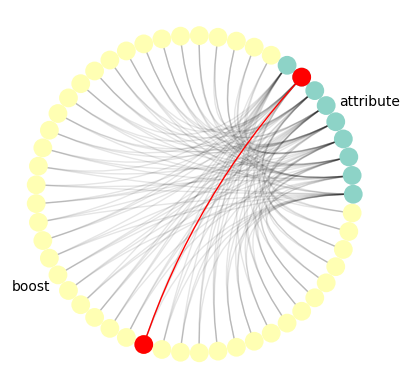

In [ ]:
ax = nv.circos(B,
               group_by="ntype",
               node_color_by="ntype"
)
annotate.circos_group(B, group_by="ntype")

# # Randomly select an edge from the graph
u, v = choice(choosen)
print("Highlighting relation between {} and {}".format(u, v))

highlights.circos_edge(B, u, v, group_by="ntype")
highlights.circos_node(B, u, group_by="ntype")
highlights.circos_node(B, v, group_by="ntype", color="red")

- I created another graph to see if it would yield better results, and it turned out to be quite good.

Highlighting relation between Speed and Merlion


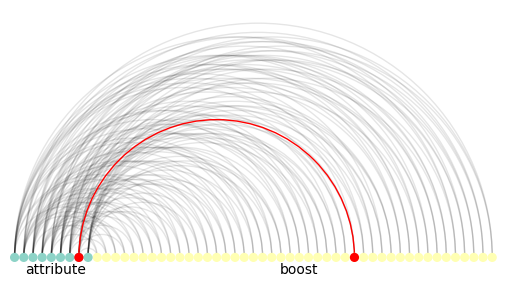

In [ ]:
ax = nv.arc(
    B, group_by="ntype", node_color_by="ntype"#, edge_alpha_by="edge_value"
)

annotate.arc_group(B, group_by="ntype", ha="center", rotation=0)


print("Highlighting relation between {} and {}".format(u, v))
highlights.arc_node(B, u, group_by="ntype")
highlights.arc_node(B, v, group_by="ntype")
highlights.arc_edge(B, source=u, target=v, group_by="ntype")

# Task 04:

- Goal:
  1. Open Task.
  2. Based on the content from classes, and considering the final configuration in the game F1 Clash derived from car parts, drivers, and bottles, propose a solution to assist a player in choosing a specific configuration.

### Setuping UP

- First, since the 'Drivers' dict is not that big, I'll create it:

In [ ]:
drivers = {
    'Verstappen': {'Overtaking': 97, 'Defending': 86, 'Qualifying': 99, 'Race_Start': 89, 'Tyre_Management': 94},
    'Leclerc': {'Overtaking': 93, 'Defending': 99, 'Qualifying': 97, 'Race_Start': 87, 'Tyre_Management': 89},
    'Alonso': {'Overtaking': 99,'Defending': 92,'Qualifying': 89,'Race_Start': 97,'Tyre_Management': 88},
    'Hamilton': {'Overtaking': 81,'Defending': 86,'Qualifying': 89,'Race_Start': 94,'Tyre_Management': 90},
    'Norris': {'Overtaking': 99,'Defending': 95,'Qualifying': 99,'Race_Start': 99,'Tyre_Management': 99},
    'Russell': {'Overtaking': 95,'Defending': 90,'Qualifying': 91,'Race_Start': 83,'Tyre_Management': 86},
    'Perez': {'Overtaking': 85,'Defending': 96,'Qualifying': 89,'Race_Start': 91,'Tyre_Management': 84},
    'Sainz': {'Overtaking': 84,'Defending': 85,'Qualifying': 95,'Race_Start': 90,'Tyre_Management': 91},
    'Stroll': {'Overtaking': 92,'Defending': 83,'Qualifying': 87,'Race_Start': 94,'Tyre_Management': 89},
    'Gasly': {'Overtaking': 88,'Defending': 93,'Qualifying': 83,'Race_Start': 85,'Tyre_Management': 96}
}

- Use the filtered CSV to create a different representation of the setups

In [ ]:
csv_data = [
  "1,171,198,174,197,3.1400000000000006,897.0",
  "2,181,198,182,169,3.24,892.0",
  "3,181,190,180,189,3.0,890.0",
  "4,145,193,184,211,3.1400000000000006,890.0",
  "5,183,171,168,206,3.2,888.0",
  "6,191,190,188,161,3.1000000000000005,885.0",
  "7,155,193,192,183,3.24,885.0",
  "8,193,171,176,178,3.3000000000000007,883.0",
  "9,155,185,190,203,3.0,883.0",
  "10,169,171,189,193,3.2200000000000006,883.0",
  "11,180,178,172,191,3.2199999999999998,882.0",
  "12,193,163,174,198,3.0600000000000005,881.0",
  "13,157,166,178,220,3.2,881.0",
  "14,165,185,198,175,3.1000000000000005,878.0",
  "15,179,171,197,165,3.3200000000000003,878.0",
  "16,190,178,180,163,3.3200000000000003,877.0",
  "17,203,163,182,170,3.16,876.0",
  "18,167,166,186,192,3.3000000000000007,876.0",
  "19,171,203,176,172,3.08,876.0",
  "20,179,163,195,185,3.08,876.0",
  "21,143,166,199,207,3.2200000000000006,876.0",
  "22,190,170,178,183,3.08,875.0",
  "23,144,192,167,211,3.22,875.0",
  "24,154,173,182,205,3.2199999999999998,875.0",
  "25,167,158,184,212,3.0600000000000005,874.0",
  "26,192,151,166,200,3.2800000000000002,873.0",
  "27,172,199,152,194,3.12,873.0",
  "28,189,163,203,157,3.1800000000000006,871.0",
  "29,153,166,207,179,3.3200000000000003,871.0",
  "30,173,171,169,199,3.1800000000000006,871.0",
  "31,174,179,176,179,3.26,871.0",
]

# Cabeçalho do novo CSV
new_columns = ['Setup', 'Speed', 'Cornering', 'Power_Unit', 'Reliability', 'Avg_PitStop_time', 'Team_Score', 'Piloto1', 'Piloto2',
               'Overtaking', 'Defending', 'Qualifying', 'Race_Start', 'Tyre_Management']


- Here a new CSV with all setups and drivers combinations is generated

In [ ]:
import csv
import itertools

# Dicionário para armazenar as informações de cada setup
setup_data = {}

# Calcular todas as combinações possíveis de pilotos 2 a 2
driver_combinations = list(itertools.combinations(drivers.keys(), 2))

# Processar os dados do CSV original e calcular as pontuações para todas as combinações de pilotos
for row in csv_data:
    values = row.split(',')
    setup = int(values[0])

    for driver1, driver2 in driver_combinations:
        data = setup_data.get((setup, driver1, driver2), {
            'Setup': setup,
            'Speed': int(values[1]),
            'Cornering': int(values[2]),
            'Power_Unit': int(values[3]),
            'Reliability': int(values[4]),
            'Avg_PitStop_time': float(values[5]),
            'Team_Score': float(values[6]),
            'Piloto1': driver1,
            'Piloto2': driver2,
        })

        piloto1_data = drivers[driver1]
        piloto2_data = drivers[driver2]

        data['Overtaking'] = piloto1_data['Overtaking'] + piloto2_data['Overtaking']
        data['Defending'] = piloto1_data['Defending'] + piloto2_data['Defending']
        data['Qualifying'] = piloto1_data['Qualifying'] + piloto2_data['Qualifying']
        data['Race_Start'] = piloto1_data['Race_Start'] + piloto2_data['Race_Start']
        data['Tyre_Management'] = piloto1_data['Tyre_Management'] + piloto2_data['Tyre_Management']

        setup_data[(setup, driver1, driver2)] = data

# Escrever os dados no novo CSV
with open('output_with_drivers.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(new_columns)
    for data in setup_data.values():
        writer.writerow([data[col] for col in new_columns])


In [ ]:
boost

In [ ]:
boost.items()

In [ ]:
import csv

# Leitura dos dados do CSV original a partir de um arquivo
csv_filename = '/content/output_with_drivers.csv'
with open(csv_filename, newline='') as csvfile:
    csv_data = list(csv.reader(csvfile))

# Cabeçalho do novo CSV
new_columns = ['Boost', 'Setup', 'Piloto1', 'Piloto2', 'Speed', 'Cornering', 'Power_Unit', 'Reliability', 'Avg_PitStop_time',
               'Overtaking', 'Defending', 'Qualifying', 'Race_Start', 'Tyre_Management']

# Dicionário para armazenar as informações de cada setup
setup_data = {}


In [ ]:
# Processar os dados do CSV original e calcular as pontuações para cada combinação de boost
for row in csv_data[1:]:  # Ignorar o cabeçalho
    setup = int(row[0])
    for boost_name, boost_values in boost.items():
        data = setup_data.get((setup, boost_name), {
            'Boost': boost_name,
            'Setup': setup,
            'Piloto1': row[7],
            'Piloto2': row[8],
            'Speed': int(row[1]) + boost_values['Speed'],
            'Cornering': int(row[2]) + boost_values['Cornering'],
            'Power_Unit': int(row[3]) + boost_values['Power_Unit'],
            'Reliability': int(row[4]) + boost_values['Reliability'],
            'Avg_PitStop_time': float(row[5]) - (boost_values['Pit_Stop'] * 0.02),
            'Overtaking': int(row[9]) + boost_values['Overtaking'],
            'Defending': int(row[10]) + boost_values['Defending'],
            'Qualifying': int(row[11]),
            'Race_Start': int(row[12]) + boost_values['Race_Start'],
            'Tyre_Management': int(row[13]) + boost_values['Tyre_Management'],
        })

        setup_data[(setup, boost_name, row[7], row[8])] = data

In [ ]:
# Escrever os dados no novo CSV
output_filename = 'output_with_boost.csv'
with open(output_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(new_columns)
    for data in setup_data.values():
        writer.writerow([data[col] for col in new_columns])

In [ ]:
1395*44


61380

In [ ]:
import pandas as pd

# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('/content/output_with_boost.csv')

In [ ]:
df.shape

(61380, 14)

In [ ]:
df.head(5)

Boost  Setup     Piloto1  Piloto2  Speed  Cornering  Power_Unit  \
0    Tsar      1  Verstappen  Leclerc    171        213         174   
1   Frost      1  Verstappen  Leclerc    171        198         174   
2   Tulip      1  Verstappen  Leclerc    171        198         174   
3  Dragon      1  Verstappen  Leclerc    171        198         189   
4  Kawaii      1  Verstappen  Leclerc    171        218         174   

   Reliability  Avg_PitStop_time  Overtaking  Defending  Qualifying  \
0          197              3.14         190        195         196   
1          207              3.14         190        185         196   
2          217              2.74         190        195         196   
3          197              3.14         210        185         196   
4          197              2.84         190        185         196   

   Race_Start  Tyre_Management  
0         176              208  
1         191              208  
2         176              183  
3         176              198  
4         191              183

In [ ]:
df.tail(5)

Boost  Setup Piloto1 Piloto2  Speed  Cornering  Power_Unit  \
61375      Nazar     31  Stroll   Gasly    174        179         176   
61376  Aderencia     31  Stroll   Gasly    174        204         176   
61377  Arco-iris     31  Stroll   Gasly    194        179         176   
61378    Eclipse     31  Stroll   Gasly    199        179         176   
61379       Rena     31  Stroll   Gasly    174        189         176   

       Reliability  Avg_PitStop_time  Overtaking  Defending  Qualifying  \
61375          194              3.26         180        176         170   
61376          194              3.26         180        176         170   
61377          179              3.26         180        201         170   
61378          179              3.06         195        176         170   
61379          179              2.86         180        196         170   

       Race_Start  Tyre_Management  
61375         204              200  
61376         189              185  
61377         184              185  
61378         179              185  
61379         179              185

In [ ]:
import pandas as pd
import numpy as np

# Adicione nós (características) ao grafo
caracteristicas = df.columns[4:]  # Exclua as colunas de identificação e Score


In [ ]:
caracteristicas

Index(['Speed', 'Cornering', 'Power_Unit', 'Reliability', 'Avg_PitStop_time',
       'Overtaking', 'Defending', 'Qualifying', 'Race_Start',
       'Tyre_Management'],
      dtype='object')

In [ ]:
# Defina os pesos das características com base na importância
pesos_das_caracteristicas = {
    'Speed': 0.25,
    'Cornering': 0.25,
    'Power_Unit': 0.05,
    'Reliability': 0.05,
    'Avg_PitStop_time': -0.2,
    'Overtaking': 0.15,
    'Defending': 0.15,
    'Qualifying': 0.15,
    'Race_Start': 0.1,
    'Tyre_Management': 0.05,
}

In [ ]:
sum_pesos = 0
for caracteristica, peso in pesos_das_caracteristicas.items():
  sum_pesos += peso

print(sum_pesos)


1.0


In [ ]:
def calcular_score(configuracao):
    score = 0
    def_score = 0
    for caracteristica, peso in pesos_das_caracteristicas.items():
      if configuracao[caracteristica] > 220:
          configuracao[caracteristica] = 220
      score += configuracao[caracteristica] * peso
    return score

# Aplique o cálculo do score no DataFrame
df['Score'] = df.apply(calcular_score, axis=1)

# Ordenar em ordem decrescente
df = df.sort_values(by='Score', ascending=False)

print("10 Melhores Configurações:")
df.head(10)



10 Melhores Configurações:


Boost  Setup     Piloto1 Piloto2  Speed  Cornering  Power_Unit  \
10417    Merlion      6     Leclerc  Norris    206        215         188   
10725    Merlion      6      Alonso  Norris    206        215         188   
10065    Merlion      6  Verstappen  Norris    206        215         188   
10425  Arco-iris      6     Leclerc  Norris    211        190         188   
10419    Caveira      6     Leclerc  Norris    216        190         198   
10421   Movember      6     Leclerc  Norris    191        215         188   
2497     Merlion      2     Leclerc  Norris    196        223         182   
10733  Arco-iris      6      Alonso  Norris    211        190         188   
2505   Arco-iris      2     Leclerc  Norris    201        198         182   
10420      Fogos      6     Leclerc  Norris    211        190         188   

       Reliability  Avg_PitStop_time  Overtaking  Defending  Qualifying  \
10417          161              2.90         192        194         196   
10725          161              2.90         198        187         188   
10065          161              2.90         196        181         198   
10425          161              3.10         192        219         196   
10419          161              3.10         207        194         196   
10421          161              3.10         192        209         196   
2497           169              3.04         192        194         196   
10733          161              3.10         198        212         188   
2505           169              3.24         192        219         196   
10420          161              3.10         207        194         196   

       Race_Start  Tyre_Management    Score  
10417         186              188  237.420  
10725         196              187  237.020  
10065         188              193  236.820  
10425         191              188  236.630  
10419         186              188  236.380  
10421         186              198  236.380  
2497          186              188  236.242  
10733         201              187  236.230  
2505          191              188  236.202  
10420         201              188  236.130